# Compare tau decay distributions between polarized and unpolarized Tauola

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyhepmc
from collections import Counter

In [3]:
def load_hepmc(filename: str) -> pd.DataFrame:
    particles = []
    with pyhepmc.open(filename, "r") as f:
        # Iterate over all events
        for i, evt in enumerate(f):
            incoming_particles = []
            outgoing_particles = []
            # Find the tau and identify its daughter tau neutrino
            for vertex in evt.vertices:
                event_number = evt.event_number
                # Check if there is a tau neutrino as incoming particle. Then store all incoming particles and the outgoing tau
                if any(np.abs(p.pid) == 16 for p in vertex.particles_in):
                    for mother in sorted(vertex.particles_in, key=lambda x: x.pid, reverse=True):
                        outgoing_particles.append([event_number, mother.pid, mother.momentum.e, mother.momentum.px, mother.momentum.py, mother.momentum.pz])
                    for dauther in vertex.particles_out:
                        if np.abs(dauther.pid) == 15:
                            outgoing_particles.append([event_number, dauther.pid, dauther.momentum.e, dauther.momentum.px, dauther.momentum.py, dauther.momentum.pz])
                    continue

                # Find the final state decay particles
                for daughter in vertex.particles_out:
                    # If it is not a final state particle, skip it
                    if daughter.status != 1:
                        continue

                    outgoing_particles.append(
                        [
                            event_number,
                            daughter.pid,
                            daughter.momentum.e,
                            daughter.momentum.px,
                            daughter.momentum.py,
                            daughter.momentum.pz
                        ]
                    )
            particles.extend(incoming_particles)
            particles.extend(outgoing_particles)

            if i % 10_000 == 0:
                print(i)

    return pd.DataFrame(particles, columns=['event_num', 'pdg', 'E', 'px', 'py', 'pz'])

decay_products = load_hepmc("tauola_output_manualpol.dat")
decay_products_nopol = load_hepmc("tauola_output_nopol.dat")
# If you want to save the DataFrame to a file, run this line
# decay_products.to_csv("tauola_decays.csv", index=False)
# decay_products_nopol.to_csv("tauola_decays_nopol.csv", index=False)


0
10000
20000
30000
40000
50000
60000
70000
0
10000
20000
30000
40000
50000
60000
70000


In [4]:
limit = 5.
event_nums = decay_products.groupby('event_num').filter(lambda df: df.iloc[1, 2] < limit)["event_num"].unique()

In [5]:
def get_particle_property(decay_products: pd.DataFrame, pdg: int, prop: str) -> tuple[pd.Series, pd.Series]:
    nutau_e = decay_products.query("pdg == 16")["px"]
    anti_nutau_e = decay_products.query("pdg == -16")["px"]
    return nutau_e, anti_nutau_e


def compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, bins, **kwargs):
    fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, layout="constrained")

    for ax, label, lists, in zip(axs, ("Neutrino", "Anti-neutrino"), ((nutau, nutau_nopol), (anti_nutau, anti_nutau_nopol))):
        for energies, particle_type in zip(lists, ("Polarized", "unpolarized")):
            ax.hist(energies, bins=bins, label=f"{label} {particle_type}", alpha=0.5)
            # ax.set_title(f"{label} {particle_type}")
            
    for ax in axs.flat:
        ax.set(**kwargs, ylabel="Number of neutrinos")
        ax.grid(True, alpha=0.5)
        ax.legend(fontsize="large")

    return fig, axs

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='px [GeV]', ylabel='Number of neutrinos'>,
        <Axes: xlabel='px [GeV]', ylabel='Number of neutrinos'>],
       dtype=object))

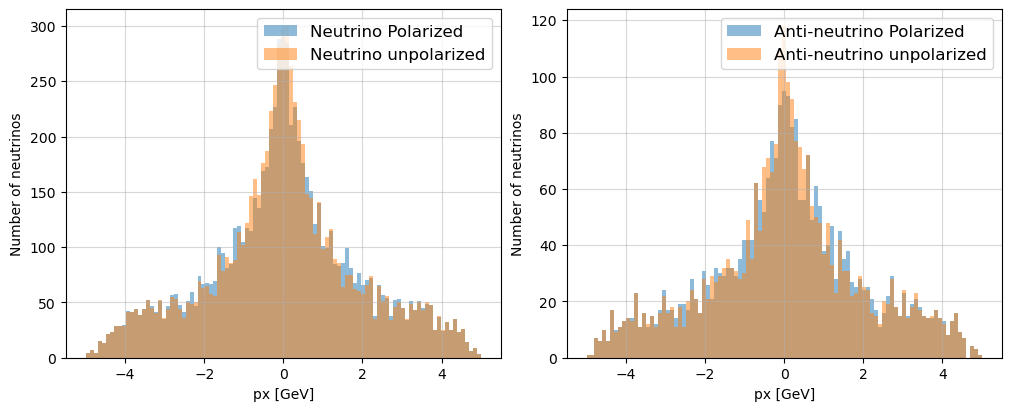

In [6]:
nutau, anti_nutau = get_particle_property(decay_products.query("event_num.isin(@event_nums)"), 16, "px")
nutau_nopol, anti_nutau_nopol = get_particle_property(decay_products_nopol.query("event_num.isin(@event_nums)"), 16, "px")

compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, bins=np.linspace(-limit, limit, 100), xlabel="px [GeV]")

## Pion momentum fraction
See Fig. 2 in the DUNE paper

In [24]:
# Only select events that decay to a pion and a neutrino (211 and 16)
pion_neutrino_events = (
    decay_products
    .groupby("event_num")
    .filter(
        lambda df: 
        (df["pdg"] == -211).any()       # There must be a pi-
        # and (df["pdg"] == 16).any()     # There must be a tau neutrino in the decays
        and (df.shape[0] == 5)          # There must be 5 particles in the event (2 incoming, 1 tau-, 2 outgoing)
        and 5 < df.iloc[1, 2] < 10.          # The incoming tau neutrino must have an energy less than 10 GeV
    )["event_num"]
    .unique()
)

pion_neutrino_events_nopol = (
    decay_products_nopol
    .groupby("event_num")
    .filter(
        lambda df: 
        (df["pdg"] == -211).any()       # There must be a pi-
        # and (df["pdg"] == 16).any()     # There must be a tau neutrino in the decays
        and (df.shape[0] == 5)          # There must be 5 particles in the event (2 incoming, 1 tau-, 2 outgoing)
        and 5 < df.iloc[1, 2] < 10.          # The incoming tau neutrino must have an energy less than 10 GeV
    )["event_num"]
    .unique()
)

In [25]:
def pion_momentum_fraction(decay_products, pion_neutrino_events):
    # Calculate the momentum fraction of the pion (row 3-4) relative to the tau (row 2)
    pion_momentum = (
        decay_products
        .query("event_num.isin(@pion_neutrino_events) and pdg.abs() == 211")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
    )
    tau_momentum = (
        decay_products
        .query("event_num.isin(@pion_neutrino_events) and pdg.abs() == 15")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
    )
    return pion_momentum.values / tau_momentum.values


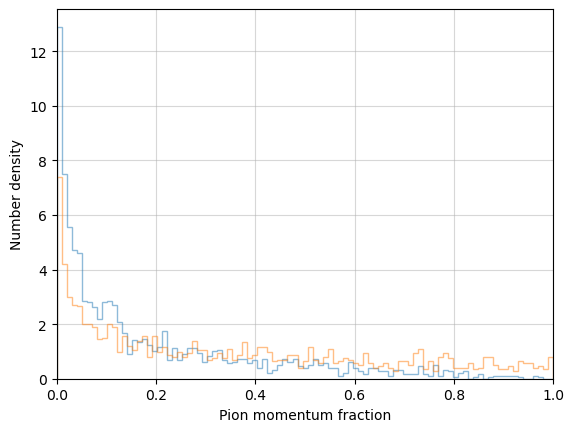

In [26]:
# Plot the momentum fraction as a histogram from 0 to 1
fig, ax = plt.subplots()
ax.hist(pion_momentum_fraction(decay_products, pion_neutrino_events), bins=np.linspace(0, 1, 100), alpha=0.5, label="Polarized", fill=False, histtype="step", density=True)
ax.hist(pion_momentum_fraction(decay_products_nopol, pion_neutrino_events_nopol), bins=np.linspace(0, 1, 100), alpha=0.5, label="Unpolarized", fill=False, histtype="step", density=True)
ax.set(xlim=(0, 1), xlabel="Pion momentum fraction", ylabel="Number density")
ax.grid(True, alpha=0.5)

When manually imposing a tau polarization, we do indeed see a difference in distribution. So Tauola is not completely useless at least. However, I need the polarization vector for every tau lepton or else I cannot get any meaningful results.